In [1]:
# !pip install pandas
# !pip install torch
# !pip install tqdm  # pip install ipywidgets or something
!pip install wandb &> /dev/null
# !pip install gensim &> /dev/null
# !pip install torchmetrics &> /dev/null

In [2]:

USING_WANDB = True  # Set to false if not Peter

if USING_WANDB:
    import wandb
    wandb.login()
    # !wandb login

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_folder = "/content/drive/MyDrive/dna_ml_model_data"
accessible_file = f"{data_folder}/accessible.fasta"
notaccessible_file = f"{data_folder}/notaccessible.fasta"
# reduced_notaccessible_file = f"{data_folder}/reduced_notaccessible.fasta"
# rest_notaccessible_file = f"{data_folder}/rest_notaccessible.fasta"
comp_file = f"{data_folder}/test.fasta"

# DATA_ZIP_FILE = "Files.zip"
# LINES_PER_SEQUENCE = 4
ACCESSIBLE_LABEL = 1
NOT_ACCESSIBLE_LABEL = 0
TEMP_SPLIT = 0.30  # validation + test
TEST_SPLIT = 0.15
PRETRAINED_DIR = "pretrained"
SOLUTION_FILE = "predictions.csv"

In [7]:
import dna_dataset, utils, CNNModel, HybridModel # , LSTMCNNModel
import torch.nn as nn, torch.optim as optim, torch
from torchvision.ops import sigmoid_focal_loss
# from tqdm.notebook import tqdm
import importlib, os, numpy as np, pandas as pd, random
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

importlib.reload(dna_dataset)
importlib.reload(utils)
importlib.reload(CNNModel)
importlib.reload(HybridModel)
# importlib.reload(LSTMCNNModel)

<module 'HybridModel' from '/content/HybridModel.py'>

In [8]:
# Credit: https://github.com/sberbank-ai/ru-dalle/blob/e96631a867fcadcfaa52eecb20b1e42b88aa4386/rudalle/utils.py
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
SEED = 1
seed_everything(SEED)

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
USING_HYBRID = False  # one hot and kmers concatenated
hybrid_k = 5  # kmer size
if not USING_HYBRID:
  hybrid_k = -1
  hybrid_k

In [ ]:
# Unzip the zip file
# !unzip $DATA_ZIP_FILE

In [9]:
# Read the data from data files
# Hybrid data
if USING_HYBRID:
    pass  # read from .pt files instead
    # acc_sequences, acc_labels, _ = dna_dataset.read_data_file(accessible_file, accessible=True, hybrid_k=hybrid_k, shuffle=True)
    # not_sequences, not_labels, _ = dna_dataset.read_data_file(notaccessible_file, accessible=False, hybrid_k=hybrid_k, shuffle=True)
    # reduced_notaccessible_file
else:
    acc_sequences, acc_labels, _ = dna_dataset.read_data_file(accessible_file, accessible=True, shuffle=True)
    not_sequences, not_labels, _ = dna_dataset.read_data_file(notaccessible_file, accessible=False, shuffle=True)

In [ ]:
# acc_sequences, acc_labels, _ = dna_dataset.read_data_file(accessible_file, accessible=True, hybrid_k=hybrid_k, shuffle=True)

In [ ]:
# # # Check how much storage each variable takes
# import sys
# def sizeof_fmt(num, suffix='B'):
#     ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 1024.0:
#             return "%3.1f %s%s" % (num, unit, suffix)
#         num /= 1024.0
#     return "%.1f %s%s" % (num, 'Yi', suffix)

# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
#                           locals().items())), key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

# Output: (k=6)
# acc_sequences: 369.1 KiB
# acc_labels: 369.1 KiB
# not_sequences:  3.5 MiB  # reduced 85%
# not_labels:  3.5 MiB

In [ ]:
# Originally used to save the hybrid data tensors to files
acc_seq_file = os.path.join(data_folder, f"{hybrid_k}k-acc_sequences.pt")
acc_lab_file = os.path.join(data_folder, f"{hybrid_k}k-acc_labels.pt")
not_seq_file = os.path.join(data_folder, f"{hybrid_k}k-not_sequences.pt")
not_lab_file = os.path.join(data_folder, f"{hybrid_k}k-not_labels.pt")
# not_seq_file = os.path.join(data_folder, "balanced_not_sequences.pt")
# not_lab_file = os.path.join(data_folder, "balanced_not_labels.pt")
# reduced_seq_file = os.path.join(data_folder, "reduced_not_sequences.pt")
# reduced_lab_file = os.path.join(data_folder, "reduced_not_labels.pt")

# torch.save(not_sequences, reduced_seq_file)  # reduced
# torch.save(not_labels, reduced_lab_file)
# torch.save(acc_sequences, acc_seq_file)  # acc
# torch.save(acc_labels, acc_lab_file)
# torch.save(not_sequences, not_seq_file)  # not
# torch.save(not_labels, not_lab_file)

In [ ]:
# Load data tensors directly from files
# acc_sequences = torch.load(acc_seq_file)
# acc_labels = torch.load(acc_lab_file)
# not_sequences = torch.load(not_seq_file)
# not_labels = torch.load(not_lab_file)
# print(not_seq_file)
# not_sequences = torch.load(not_seq_file)
# not_labels = torch.load(not_lab_file)
# print(len(not_sequences))
assert(len(not_sequences) == len(not_labels))
assert(len(acc_sequences) == len(acc_labels))
print(not_sequences[0].shape)

torch.Size([4, 456])


In [ ]:
acc_sequences[0].shape

torch.Size([4, 456])

In [12]:
num_acc = len(acc_sequences)
num_not = len(not_sequences)
full_size = num_acc + num_not
print(f"full size: {full_size} num_acc: {num_acc} num_not: {num_not}")

# Split accessible data into train val test split

acc_seq_train, acc_seq_temp, acc_lab_train, acc_lab_temp = train_test_split(acc_sequences, acc_labels, test_size=TEMP_SPLIT, random_state=SEED)
acc_seq_val, acc_seq_test, acc_lab_val, acc_lab_test = train_test_split(acc_seq_temp, acc_lab_temp, test_size=TEST_SPLIT/TEMP_SPLIT, random_state=SEED)

# Split not accessible data into train val test split
not_seq_train, not_seq_temp, not_lab_train, not_lab_temp = train_test_split(not_sequences, not_labels, test_size=TEMP_SPLIT, random_state=SEED)
not_seq_val, not_seq_test, not_lab_val, not_lab_test = train_test_split(not_seq_temp, not_lab_temp, test_size=TEST_SPLIT/TEMP_SPLIT, random_state=SEED)

# assert(len(acc_sequences) == len(acc_labels) == len(acc_seq_train) + len(acc_seq_val) + len(acc_seq_test))
# assert(len(not_sequences) == len(not_labels) == len(not_lab_train) + len(not_lab_val) + len(not_lab_test))

full size: 525688 num_acc: 47239 num_not: 478449


Upsample or Downsample the dataset  
(AFTER splitting to train/validation/test to prevent data leakage)

In [13]:
UPSAMPLE = False  # Only set one or the other
DOWNSAMPLE = False
if UPSAMPLE:
    num_diff = len(not_seq_train) - len(acc_seq_train)
    # upscale the minority
    upsampled_acc_seq, upsampled_acc_lab = resample(acc_seq_train, acc_lab_train, n_samples=num_diff, random_state=1)
    actual_acc_seq_train = acc_seq_train + upsampled_acc_seq
    actual_acc_lab_train = acc_lab_train + upsampled_acc_lab
else:
    actual_acc_seq_train = acc_seq_train
    actual_acc_lab_train = acc_lab_train
# consider upweighting for calibration
if DOWNSAMPLE:
    # downsample the majority
    # just take the first part len(acc_seq_train) samples
    actual_not_seq_train = not_seq_train[:len(acc_seq_train)]
    actual_not_lab_train = not_lab_train[:len(acc_seq_train)]
    # Adding rest of data to test and val
    rest_not_sequences, rest_not_labels = not_seq_train[len(acc_seq_train):], not_lab_train[len(acc_seq_train):]
    print("Rest not seq and labs ", len(rest_not_sequences), len(rest_not_labels))
    assert(len(rest_not_sequences) + len(actual_not_seq_train) == len(not_seq_train))
    # ensure the data is now equal
    assert(len(actual_acc_seq_train) == len(actual_not_seq_train))
else:
    actual_not_seq_train = not_seq_train
    actual_not_lab_train = not_lab_train
print("Actual train not seq and labs ", len(actual_not_seq_train), len(actual_not_lab_train))
print("Actual train acc seq and labs ", len(actual_acc_seq_train), len(actual_acc_lab_train))

Actual train not seq and labs  334914 334914
Actual train acc seq and labs  33067 33067


In [14]:
# Create the (shuffled) datasets, after appending the lists
sequences_train = actual_acc_seq_train + actual_not_seq_train
labels_train = actual_acc_lab_train + actual_not_lab_train
train_dataset = dna_dataset.DNADataset(sequences_train, labels_train)
num_train = len(train_dataset)
print("train samples", num_train)
assert(len(sequences_train) == len(labels_train) == num_train)

sequences_val = acc_seq_val + not_seq_val
labels_val = acc_lab_val + not_lab_val
val_dataset = dna_dataset.DNADataset(sequences_val, labels_val)
print("val samples", len(val_dataset))

sequences_test = acc_seq_test + not_seq_test
labels_test = acc_lab_test + not_lab_test
test_dataset = dna_dataset.DNADataset(sequences_test, labels_test)
print("test samples", len(test_dataset))

# if DOWNSAMPLE:
#     rest_notacc_dataset = dna_dataset.DNADataset(rest_not_sequences, rest_not_labels)
#     print("rest not samples", len(rest_notacc_dataset))

train samples 367981
val samples 78853
test samples 78854


In [15]:
# Check things are the right size
if DOWNSAMPLE:
  print(len(sequences_train) + len(sequences_val) + len(sequences_test) + len(rest_not_sequences), full_size)
  assert(len(sequences_train) + len(sequences_val) + len(sequences_test) + len(rest_not_sequences) == full_size)
elif UPSAMPLE:
  pass
else:
  print(len(sequences_train) + len(sequences_val) + len(sequences_test), full_size)
  assert(len(sequences_train) + len(sequences_val) + len(sequences_test) == full_size)

# Ensure the DNADataset is loaded properly
print('total sequences', full_size)
print('num accessible', num_acc)
print('num not accessible', num_not)
i = 0
print(f"example entry {i}")
item = train_dataset[i]
# print(item['sequence'])  # long answer
print("label", item['label'])
# ensure dataset was shuffled properly
# check that not all the accessible labels are at the front
for i in range(len(train_dataset)):
    if train_dataset[i]['label'] != ACCESSIBLE_LABEL:
        print('shuffled')
        break
# Balanced: total sequences 94478  num accessible 47239  num not accessible 47239
# Full (imbalanced) total sequences 525688  num accessible 47239  num not accessible 478449

525688 525688
total sequences 525688
num accessible 47239
num not accessible 478449
example entry 0
label 0
shuffled


In [16]:
# # Free up memory
# del sequences_train, labels_train, sequences_val, labels_val, sequences_test, labels_test
# del acc_seq_train, not_seq_train, acc_lab_train, not_lab_train
# del acc_seq_val, not_seq_val, acc_lab_val, not_lab_val
# del acc_seq_test, not_seq_test, acc_lab_test, not_lab_test

In [131]:
# Initialize model
importlib.reload(dna_dataset)
importlib.reload(utils)
importlib.reload(CNNModel)
importlib.reload(HybridModel)
torch.manual_seed(SEED)

kernel_size = 3     # should use odd size
embed_dim = 4
conv_filters = [200,300,300,300] #[64, 128, 256, 384, 448]  # [64, 128]
pool_kernel_size = 2  # 2
linear_neurons = [128]  #[64,32]
dropout_rate_Dense = 0.5  # .5

cnn_out_size=128
ffn_out_size=16

# insert torch model here, that takes sequence as input and output a label 0 or 1
base_model = CNNModel.CNNModel(kernel_size, embed_dim, conv_filters, pool_kernel_size,
                           linear_neurons, dropout_rate_Dense)
total_hidden = sum(conv_filters) + sum(linear_neurons) - (4 + 1)
print(f"{total_hidden} total hidden")

# base_model = HybridModel.HybridModel(kernel_size, embed_dim, conv_filters, pool_kernel_size,
#                            linear_neurons, dropout_rate_Dense, cnn_out_size, ffn_out_size, k=hybrid_k)

base_model.to(device)  # quiet output
# sum(linear_neurons)

1223 total hidden


CNNModel(
  (Convs): ModuleList(
    (0): Conv1d(4, 200, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(200, 300, kernel_size=(3,), stride=(1,), padding=(1,))
    (2-3): 2 x Conv1d(300, 300, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linears): ModuleList(
    (0): Linear(in_features=3600, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=1, bias=True)
  )
  (dropout_Dense): Dropout(p=0.5, inplace=False)
  (dropout_Conv): Dropout(p=0.2, inplace=False)
  (sigmoid): Sigmoid()
)

In [132]:
# Loss Function and weight
# All weights were the same
# WEIGHTED_LOSS = None
WEIGHTED_LOSS = "sklearn type weight"
# WEIGHTED_LOSS = "Inverse Sqrt Weight"
# WEIGHTED_LOSS = "sigmoid_focal_loss"  # try sigmoid_focal_loss

# https://medium.com/gumgum-tech/handling-class-imbalance-by-introducing-sample-weighting-in-the-loss-function-3bdebd8203b4

weight_class0 = 1
# weight_for_class_i = total_samples / (num_samples_in_class_i * num_classes)
if WEIGHTED_LOSS == "sklearn type weight":
    weight_class0 = torch.Tensor([num_train / len(actual_not_seq_train) * 2]).to(device)
    weight_class1 = torch.Tensor([num_train / len(actual_acc_seq_train) * 2]).to(device)
    # = (n_0 + n_1) / (2.0 * n_1)
# Balanced class weights: weight = total_samples / (num_classes * frequency)
elif WEIGHTED_LOSS == "Balanced Class Weight":  # same results as sklearn type weight
    weight_class1 = num_train / len(actual_acc_seq_train) * 2
# Inverse class frequency: weight = 1 / frequency
elif WEIGHTED_LOSS == "Inverse Class Frequency Weight":  # same results as sklearn type weight
    weight_class1 = len(actual_not_seq_train) / len(actual_acc_seq_train)
# Slightly worse then the rest
elif WEIGHTED_LOSS == "Inverse Sqrt Weight":
    weight_class0 = 1 / np.sqrt(len(actual_not_seq_train))
    weight_class1 = 1 / np.sqrt(len(actual_acc_seq_train))

if WEIGHTED_LOSS == "sigmoid_focal_loss":
    loss_fn = sigmoid_focal_loss

elif WEIGHTED_LOSS != None:
    pos_weight = weight_class1 / weight_class0
    print(f"pos_weight {pos_weight}")
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([pos_weight]).to(device))
    # loss_fn = utils.weighted_binary_cross_entropy
    try:
      print("weight for class 0", weight_class0)
    except:
      pass
    print("weight for class 1", weight_class1)

else:
    loss_fn = nn.BCEWithLogitsLoss()  # (reduction='none') ??
    # loss_fn = utils.f1_loss
    # loss_fn = utils.macro_double_soft_f1

# if loss_fn.__class__.__name__ == "BCELoss" or loss_fn.__class__.__name__ == "function":
if loss_fn.__class__.__name__ != "BCEWithLogitsLoss":
    model = nn.Sequential(base_model, nn.Sigmoid())  # Add Sigmoid to model if using BCELoss
    print("Added sigmoid")
else:
    model = base_model
model.to(device);

pos_weight tensor([10.1283], device='cuda:0')
weight for class 0 tensor([2.1975], device='cuda:0')
weight for class 1 tensor([22.2567], device='cuda:0')


In [133]:
epochs = 5
batch_size = 128
learning_rate = .0001
weight_decay = .01

In [134]:
# parameters
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=.01)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)  # pretty bad

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, worker_init_fn=seed_worker, generator=g) # shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, worker_init_fn=seed_worker, generator=g)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, worker_init_fn=seed_worker, generator=g)
# del train_dataset, val_dataset, test_dataset

In [135]:
# USING_WANDB = True
if model.__class__.__name__ == "HybridModel":
    note = f"{conv_filters}-conv-{linear_neurons}-{cnn_out_size}-{ffn_out_size}lin-{model.__class__.__name__}"
else:
    note = f"{conv_filters}-conv-lin-{linear_neurons}-{model.__class__.__name__}"
# {hybrid_k}mer-
note

'[200, 300, 300, 300]-conv-lin-[128]-CNNModel'

In [ ]:
# TRAINING LOOP
# USING_WANDB = False
if USING_WANDB and epochs != 1:  # usually if epochs = 1, i'm continuing a prev run
    # note = f"{optimizer.__class__.__name__}-{kernel_size}-kernel-{num_filters1}-{num_filters2}-conv-{hidden_dense1}-{hidden_dense2}-dense" # "lstm_no_dropout" # "0.5_dropout"
    wandb.init(
        project="dna_ml_model",
        # name=f"experiment_{run}"
        name=f"{note}",
        settings=wandb.Settings(start_method="fork"),
        config = {
            "architecture": model.__class__.__name__,
            "epochs": epochs,
            "learning_rate": learning_rate,
            "batch_size": batch_size,
            "optimizer": optimizer.__class__.__name__,
            "loss fn": loss_fn.__class__.__name__,
            "weighted loss1": WEIGHTED_LOSS,
            "weight decay": weight_decay,
            "notes": note
    })

best_acc = 0.0

for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")

    running_loss = 0.0
    running_corrects = 0.0

    CM = 0  # confusion matrix

    model.train()
    for batch in train_loader:  # tqdm()

        samples, labels = batch["sequence"].to(device), batch['label'].to(device)

        outputs = model(samples).flatten()

        labels = labels.reshape(-1,1).float().flatten()

        # Backpropagation and gradient descent

        if loss_fn.__class__.__name__ == "function" and loss_fn.__name__ == "weighted_binary_cross_entropy":
            loss = loss_fn(outputs, labels, [weight_class0, weight_class1])
        else:
            loss = loss_fn(outputs, labels) #, reduction="mean")
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()  # reset gradients before next iteration

        running_loss += loss.item() * samples.size(0)  # loss per sample times batch size

        preds = utils.get_preds(outputs)
        running_corrects += torch.sum(preds == labels.data).item()
        CM += confusion_matrix(labels.cpu().flatten().detach().numpy(), preds.cpu().flatten().detach().numpy())

    # Calculate recall, precision, f1 score
    acc_score, precision, recall, f1 = utils.compute_metrics(CM)

    # if step % n_eval == 0:
    # Compute training loss and accuracy.
    with torch.no_grad():
        model.eval()
        val_loss, val_acc, val_precision, val_recall, val_f1, val_pr_auc = utils.evaluate(val_loader, model, loss_fn, device)

    epoch_loss = running_loss / num_train
    epoch_acc = running_corrects / num_train
    print(f"""Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {f1:.4f}
          Precision {precision:.4f} Recall: {recall:.4f}""")
    print(f"""Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}
          Precision {val_precision:.4f} Recall: {val_recall:.4f} F1: {val_f1:.4f}
          PR auc: {val_pr_auc:.4f}""")

    # # deep copy the model
    # if val_accuracy > best_acc:
    #     best_acc = epoch_acc
    #     torch.save(model.state_dict(), best_model_params_path)

    if USING_WANDB:
        wandb.log({"Train Loss": epoch_loss,
                    "Val Loss": val_loss,
                    "Train Precision": precision,
                    "Val Precision": val_precision,
                    "Val Recall": val_recall,
                    "Train F1": f1,
                    "Val F1": val_f1,
                    "Val Acc": val_acc,
                    "Train Acc": epoch_acc,
                    # "Val ROC AUC": val_roc_auc
                    "Val PR AUC": val_pr_auc
                  #  "Epoch": epoch
        })
        # step += 1

    print()

Epoch 1 of 5
Training Loss: 0.9393 Acc: 0.8606 F1: 0.3468
          Precision 0.2995 Recall: 0.4119
Validation Loss: 519.2017 Acc: 0.8417
          Precision 0.3147 Recall: 0.6472 F1: 0.4235
          PR auc: 0.2354

Epoch 2 of 5
Training Loss: 0.7599 Acc: 0.8895 F1: 0.4911
          Precision 0.4190 Recall: 0.5933
Validation Loss: 441.0805 Acc: 0.8911
          Precision 0.4294 Recall: 0.6437 F1: 0.5151
          PR auc: 0.3084

Epoch 3 of 5


In [130]:
# wandb.finish()

Train Acc,▁▄▆▇█
Train F1,▁▅▆▇█
Train Loss,█▅▃▂▁
Train Precision,▁▄▆▇█
Val Acc,▁▃▃▆█
Val F1,▁▃▅▇█
Val Loss,█▆▃▁▁
Val PR AUC,▁▃▅▇█
Val Precision,▁▃▃▆█
Val Recall,▁▃▇█▇
Train Acc,0.91699


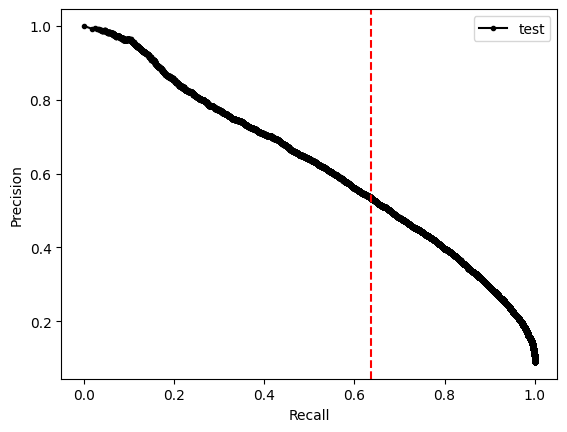

Best Threshold 0.7746405005455017 with F-Score 0.5816727929322241 for test dataset


In [121]:
# Precision recall plot for finding optimal threshold

import matplotlib.pyplot as plt
which_dataset = "val"  # test
which_dataset = "test"
dataset = val_dataset if which_dataset == "val" else test_dataset
dataloader = val_loader if which_dataset == "val" else test_loader

total_probs = np.empty(0)
total_labels = np.empty(0)  # don't need to have same order
model.eval()
# Calculate the probs
for batch in dataloader:
    samples, labels = batch['sequence'].to(device), batch['label'].to(device)

    if loss_fn.__class__.__name__ == "BCEWithLogitsLoss":
        outputs = model(samples, use_sigmoid=True)
    else:
        outputs = model(samples)

    total_probs = np.concatenate((total_probs, outputs.flatten().cpu().detach().numpy()))
    total_labels = np.concatenate((total_labels, labels.flatten().cpu().detach().numpy()))

precisions, recalls, thresholds = precision_recall_curve(dataset.list2, total_probs)
# pearson correlation coeffs?
# dataset.list2  # list of all labels

plt.plot(recalls, precisions, marker='.', label=which_dataset, color="black")
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
fscores = (2 * precisions * recalls) / (precisions + recalls)

# Turn nan values to 0
fscores[np.isnan(fscores)] = 0

# locate the index of the largest f score
ix = np.argmax(fscores)
best_threshold = thresholds[ix]
plt.plot(recalls[ix], precisions[ix], color="red")
plt.axvline(recalls[ix], ls='--', color="red", label="Best F-Score")
# show the plot
plt.show()
print(f"Best Threshold {thresholds[ix]} with F-Score {fscores[ix]} for {which_dataset} dataset")
# Typically around 70-75%

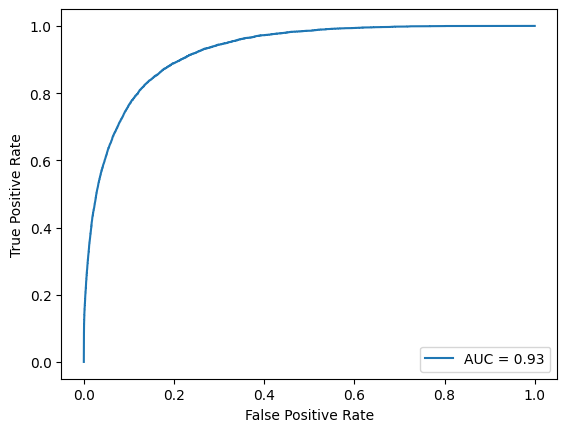

In [122]:
from sklearn import metrics
fpr, tpr, roc_thresholds = metrics.roc_curve(total_labels, total_probs)
auc_score = metrics.roc_auc_score(total_labels, total_probs)
roc_auc = metrics.auc(fpr, tpr)
assert(auc_score == roc_auc)  # if not, then change code in evaluate() to use metrics.auc() instead
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
# print(auc_score)
# plt.show()

Using threshold 0.7746405005455017
Final Test Accuracy: 91.75879906684247 %
Final Test Precision: 53.54601518026565 %
Final Test Recall: 63.609467455621306 %
Final Test F1 Score: 58.14552479072762 %
Final roc_auc: 79.09150543037774 %
Final pr_auc: 37.34395687411185 %


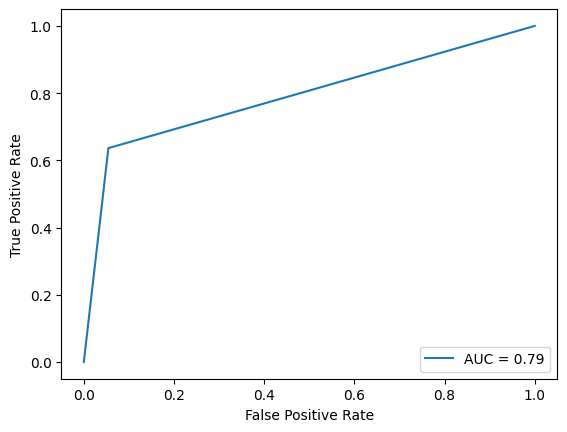

In [124]:
# EVALUATE on test dataset
total_predictions = 0
total_correct = 0

model.eval()

CM = 0  # confusion matrix
total_probs = np.empty(0)
total_labels = np.empty(0)

print(f"Using threshold {best_threshold}")
for batch in test_loader:  # tqdm()

    test_samples, test_labels = batch['sequence'].to(device), batch['label'].to(device)

    if loss_fn.__class__.__name__ == "BCEWithLogitsLoss":
        test_outputs = model(test_samples, use_sigmoid=True)
    else:
        test_outputs = model(test_samples)

    test_preds = utils.get_preds(test_outputs, threshold=best_threshold)

    test_labels = test_labels.reshape(-1, 1).float()

    test_loss = loss_fn(test_outputs, test_labels).item()  # change tensor to single val

    total_predictions += len(test_outputs)

    CM += confusion_matrix(test_labels.flatten().cpu().detach().numpy(), test_preds.cpu().flatten().detach().numpy())

    total_probs = np.concatenate((total_probs, test_outputs.flatten().cpu().detach().numpy()))
    total_labels = np.concatenate((total_labels, test_labels.flatten().cpu().detach().numpy()))

# Computer accuracy, precision, recall, and f1 metrics
acc_score, precision, recall, f1 = utils.compute_metrics(CM)

fpr, tpr, roc_thresholds = metrics.roc_curve(total_labels, total_probs)
pr_auc = average_precision_score(total_labels, total_probs)
# auc_score = metrics.roc_auc_score(total_labels, total_probs)  # both the same
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

print(f"Final Test Accuracy: {acc_score * 100} %")
print(f"Final Test Precision: {precision * 100} %")
print(f"Final Test Recall: {recall * 100} %")
print(f"Final Test F1 Score: {f1 * 100} %")
print(f"Final roc_auc: {roc_auc * 100} %")
print(f"Final pr_auc: {pr_auc * 100} %")
display.plot()

if USING_WANDB:
    wandb.summary['test_accuracy'] = acc_score
    wandb.summary['test_precision'] = precision
    wandb.summary['test_recall'] = recall
    wandb.summary['test_f1_score'] = f1
    wandb.summary['roc_auc'] = roc_auc
    wandb.summary['pr_auc'] = pr_auc

    # wandb.finish()  # first check if code runs right

In [ ]:
wandb.finish()

Train Acc,▁▄█▆▆
Train F1,▁▅▇██
Train Loss,█▄▂▁▁
Train Precision,▁▅█▇▇
Val Acc,▅▇▁█▁
Val F1,▁▆▇██
Val Loss,█▃▂▂▁
Val Precision,█▇▁█▁
Val ROC AUC,▁▅▇▇█
Val Recall,▁▅▇▇█
Train Acc,0.91183


In [ ]:
print(f"Note: Actual Test {len(acc_seq_test)} accessible and {len(not_seq_test)} notaccessible")

Note: Actual Test 7086 accessible and 71768 notaccessible


Save Model

In [ ]:
# !rm -r pretrained
# !rm predictions.zip

In [110]:
# Create pretrained directory if not yet created
if not os.path.isdir(PRETRAINED_DIR):
    os.mkdir(PRETRAINED_DIR)

now = datetime.now()
datetime_str = now.strftime("%m-%d-%H-%M-%S")
model_save_path = os.path.join(
    PRETRAINED_DIR,
    f'{note}{datetime_str}.pt'
)
print('model_save_path', model_save_path)

if model.__class__.__name__ == "CNNModel":
    CNNModel.save_CNNModel(model_save_path, base_model)  # model without the added sigmoid
elif model.__class__.__name__ == "HybridModel":
    HybridModel.save_HybridModel(model_save_path, base_model)
print(f"model saved at {datetime_str}")

model_save_path pretrained/[200, 300, 300, 300]-conv-lin-[256]-CNNModel01-13-01-15-27.pt
model saved at 01-13-01-15-27


Load Model

In [112]:
# Add the new path
model_save_path = ""
model = CNNModel.load_CNNModel(model_save_path)
# model = HybridModel.load_HybridModel(model_save_path)
model.to(device);

Inference on Competition File

In [34]:
# Load Competitation Data
# Set shuffle=False to save time, unnecessary for comp file
if USING_HYBRID:
    pass
    # comp_sequences, _, comp_ids = dna_dataset.read_data_file(comp_file, labeled=False, hybrid_k=hybrid_k, shuffle=False)
else:
    comp_sequences, _, comp_ids = dna_dataset.read_data_file(comp_file, labeled=False, shuffle=False)

In [ ]:
# Load tensors directly from data files
comp_seq_file = os.path.join(data_folder, f"{hybrid_k}k-comp_sequences.pt")
comp_id_file = os.path.join(data_folder, f"{hybrid_k}k-comp_ids.pt")

# torch.save(comp_sequences, comp_seq_file)  # save
# torch.save(comp_ids, comp_id_file)

comp_sequences = torch.load(comp_seq_file)  # load
comp_ids = torch.load(comp_id_file)

In [35]:
competition_dataset = dna_dataset.DNADataset(comp_sequences, comp_ids, comp=True)
competition_loader = torch.utils.data.DataLoader(competition_dataset, batch_size=batch_size)
print("Competition dataset loaded.")

Competition dataset loaded.


In [ ]:
# loss_fn = nn.BCEWithLogitsLoss()

In [102]:
probs = []  # tuples of probability, id

model.eval()
for batch in competition_loader:  # tqdm()
    samples, ids = batch["sequence"].to(device), batch['id']  # not a tensor

    if loss_fn.__class__.__name__ == "BCEWithLogitsLoss":
        outputs = model(samples, use_sigmoid=True)
    else:
        outputs = model(samples)

    try:
        assert(len(outputs[outputs>1]) == 0 and len(outputs[outputs<0]) == 0)  # ensure all probs are [0,1]
    except:
        placeholder = 0
        print(outputs[outputs>1][0])
        print(outputs[outputs<0][0])
        raise

    out_list = outputs.tolist()
    for i in range(len(out_list)):
        probs.append((out_list[i], ids[i]))

print("Finished inference")

# print(np_probs[np_probs>0.0 and np_probs<1.0])

Finished inference


In [103]:
threshold = best_threshold  # .993
print(f"using threshold {best_threshold}")

using threshold 0.6806178092956543


In [104]:
# View the results
np_probs = np.array(list(zip(*probs))[0])
not_probs = np_probs[np_probs<=threshold]
not_probs.sort()
acc_probs = np_probs[np_probs>threshold]
print("Predicted", len(acc_probs), "true values out of ", len(np_probs), " total", len(acc_probs) * 100 / len(np_probs), "percent")
print(f"Note: 10,000 / {len(competition_dataset)} is {10000 / len(competition_dataset):.4f}")
acc_probs[::-1].sort()
print()
print("not accessible probs", not_probs)
print("accessible probs", acc_probs)
assert(len(np_probs[np_probs>1]) == 0 and len(np_probs[np_probs<0]) == 0)  # ensure all probs are [0,1]

print()

probs.sort(reverse=True)
print("first 10\n", list(zip(*probs[:10]))[0])
print("last 10 of top 10000\n", list(zip(*probs[9990:10000]))[0])  # probs only

highest_probs = probs[:10000]  # top 10,000

Predicted 33358 true values out of  269315  total 12.386239162319217 percent
Note: 10,000 / 269315 is 0.0371

not accessible probs [1.26218425e-18 5.25878006e-18 7.18765358e-18 ... 6.80541396e-01
 6.80581212e-01 6.80588722e-01]
accessible probs [1.         1.         1.         ... 0.68066913 0.68066883 0.68064821]

first 10
 ([1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0])
last 10 of top 10000
 ([0.9781096577644348], [0.9780938029289246], [0.9780675768852234], [0.9780647158622742], [0.9780580401420593], [0.9780543446540833], [0.9780460596084595], [0.9780424237251282], [0.9780421853065491], [0.9780341982841492])


In [105]:
# !rm $zip_file_name

In [106]:
with open(SOLUTION_FILE, "w") as f:
    for pair in highest_probs:
        f.write(pair[1])
        f.write("\n")

In [107]:
zip_file_name = "predictions.zip"
!zip $zip_file_name $SOLUTION_FILE
!rm $SOLUTION_FILE

updating: predictions.csv (deflated 66%)


In [109]:
from google.colab import files
files.download(zip_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ONLY for use on google colab. download files
from google.colab import files
import os
model_file = os.path.join(PRETRAINED_DIR, os.listdir(PRETRAINED_DIR)[0])
files.download(model_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>